### Реализация алгоритма градиентного бустинга<a class='anchor' id='implement'>

Реализуем средствами Python алгоритм градиентного бустинга для деревьев решений.

Реализация деревьев решений была дважды продемонстрирована в предыдущих уроках, в этом не будем ее повторять и возьмем готовую реализацию дерева решений для регрессии из библиотеки `sklearn`.

In [31]:
from sklearn import model_selection
from sklearn.tree import DecisionTreeRegressor
from sklearn.datasets import load_diabetes
import matplotlib.pyplot as plt
import numpy as np

Используем один из "игрушечных" датасетов из той же библиотеки.

In [32]:
X, y = load_diabetes(return_X_y=True)
X.shape, y.shape

((442, 10), (442,))

Разделим выборку на обучающую и тестовую в соотношении 75/25.

In [33]:
X_train, X_test, y_train, y_test = model_selection.train_test_split(X, y, test_size=0.25)

Напишем функцию, реализующую предсказание в градиентном бустинге.

In [34]:
def gb_predict(X, trees_list, eta):
    # Реализуемый алгоритм градиентного бустинга будет инициализироваться нулевыми значениями,
    # поэтому все деревья из списка trees_list уже являются дополнительными и при предсказании
    # прибавляются с шагом eta
    
#     predictions = np.zeros(X.shape[0])
#     for i, x in enumerate(X):
#         prediction = 0
#         for alg in trees_list:
#             prediction += eta * alg.predict([x])[0]
#         predictions[i] = prediction
        
    predictions = np.array(
        [sum([eta * alg.predict([x])[0] for alg in trees_list]) for x in X]
    )

    return predictions

В качестве функционала ошибки будем использовать среднеквадратичную ошибку. Реализуем соответствующую функцию.

In [35]:
def mean_squared_error(y_real, prediction):
    return (sum((y_real - prediction)**2)) / len(y_real)

Используем $L_{2}$ loss $L(y, z) = (y - z)^{2},$ ее производная по $z$ примет вид $L'(y, z) = 2(z - y)$. Реализуем ее также в виде функции (коэффициент 2 можно отбросить).

In [36]:
def residual(y, z):
    return - (z - y)

Реализуем функцию обучения градиентного бустинга.

In [37]:
def gb_fit(n_trees, max_depth, X_train, X_test, y_train, y_test, eta):
    
    # Деревья будем записывать в список
    trees = []
    
    # Будем записывать ошибки на обучающей и тестовой выборке на каждой итерации в список
    train_errors = []
    test_errors = []
    
    for i in range(n_trees):
        tree = DecisionTreeRegressor(max_depth=max_depth, random_state=42)

        # первый алгоритм просто обучаем на выборке и добавляем в список
        if len(trees) == 0:
            # обучаем первое дерево на обучающей выборке
            tree.fit(X_train, y_train)
            
            train_errors.append(mean_squared_error(y_train, gb_predict(X_train, trees, eta)))
            test_errors.append(mean_squared_error(y_test, gb_predict(X_test, trees, eta)))
        else:
            # Получим ответы на текущей композиции
            target = gb_predict(X_train, trees, eta)
            
            # алгоритмы начиная со второго обучаем на сдвиг
            tree.fit(X_train, residual(y_train, target))
            
            train_errors.append(mean_squared_error(y_train, gb_predict(X_train, trees, eta)))
            test_errors.append(mean_squared_error(y_test, gb_predict(X_test, trees, eta)))

        trees.append(tree)
        
    return trees, train_errors, test_errors

## Домашнее задание<a class='anchor' id='hw'>

__1. Для реализованной модели градиентного бустинга построить графики зависимости ошибки от количества деревьев в ансамбле и от максимальной глубины деревьев. Сделать выводы о зависимости ошибки от этих параметров.__

In [38]:
eta = 1
max_depths = range(1, 15)


def max_depth_difference(n_trees=3, max_depths=max_depths):
    train_errors_depths = []
    test_errors_depths = []

    for max_depth in max_depths:
        _, train_errors, test_errors = gb_fit(n_trees, max_depth, X_train, X_test, y_train, y_test, eta)
        train_errors_depths.append(train_errors[-1])
        test_errors_depths.append(test_errors[-1])


    print(f'Количество деревьев {n_trees}')
    plt.plot(range(len(max_depths)), train_errors_depths, label='train_error')
    plt.plot(range(len(max_depths)), test_errors_depths, label='test_error')
    plt.title('Зависимость ошибки от максимальной глубины деревьев')
    plt.xlabel('Глубина дерева')
    plt.ylabel('MSE')
    plt.legend()

Количество деревьев 3


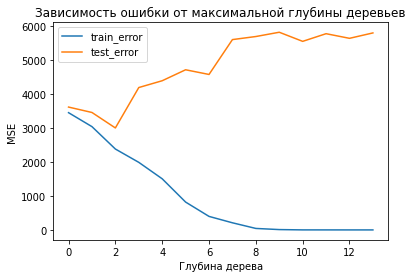

In [39]:
max_depth_difference(max_depths=max_depths, n_trees=3)

Количество деревьев 5


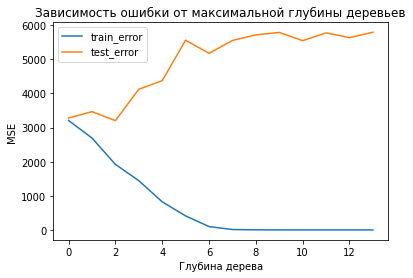

In [40]:
max_depth_difference(max_depths=max_depths, n_trees=5)

Количество деревьев 10


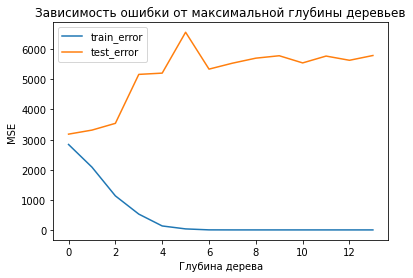

In [41]:
max_depth_difference(max_depths=max_depths, n_trees=10)

Количество деревьев 15


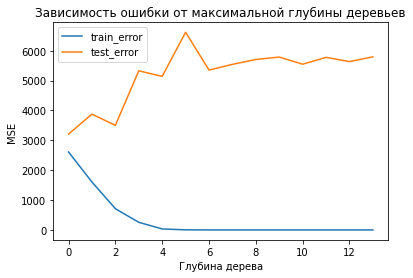

In [42]:
max_depth_difference(max_depths=max_depths, n_trees=15)

__Ошибка на тренировочной выборке уменьшается при увеличении глубины дерева, но на тестовой выборке наоборот растёт__

In [43]:
eta = 1
n_trees = list(range(1, 20, 5))


def trees_num(n_trees=n_trees, max_depth=3):
    train_errors_trees = []
    test_errors_trees = []

    for n in n_trees:
        _, train_errors, test_errors = gb_fit(n, max_depth, X_train, X_test, y_train, y_test, eta)
        train_errors_trees.append(train_errors[-1])
        test_errors_trees.append(test_errors[-1])


    print(f'Максимальная глубина дерева {max_depth}')
    plt.plot(range(len(n_trees)), train_errors_trees, label='train_error')
    plt.plot(range(len(n_trees)), test_errors_trees, label='test_error')
    plt.title('Зависимость ошибки от количества деревьев')
    plt.xlabel('Количество деревьев')
    plt.ylabel('MSE')
    plt.xticks(n_trees)
    plt.legend()

Максимальная глубина дерева 3


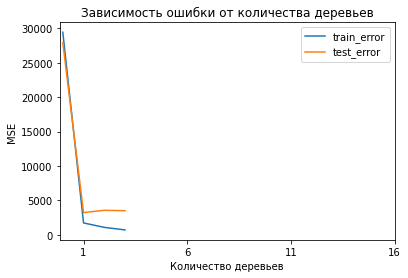

In [44]:
trees_num(n_trees=n_trees, max_depth=3)

__При увеличении количества деревьев ошибка на трейне уменьшается, а на тесте начинает расти__